# Solving the TSP with the `evolvepy` Framework

This notebook demonstrates how to use the `evolvepy` framework to solve a combinatorial optimization problem: the **Traveling Salesman Problem (TSP)**.

We will walk through the following steps:
1.  **Setup:** Import all necessary modules and define experiment parameters.
2.  **Problem Setup:** Load the data and instantiate the `TSPProblem` class.
3.  **Strategy Assembly:** Select and configure the "plugins" (Crossover, Mutation, Selection) for our engine.
4.  **Engine Initialization:** Create an instance of `EvolutionaryAlgorithm` and "inject" our prepared strategies.
5.  **Execution:** Run the algorithm.
6.  **Analysis:** Use the returned `history` object to plot the results with our analysis module.

**Prerequisite: Installation**

Ensure you have installed the framework and its optional analysis dependencies from the terminal, in the project's root folder:

In [1]:
#!pip install -e ".[analysis,dev]"

In [2]:
# Import standard libraries
import numpy as np
import glob
from typing import List, Dict, Any

# Import core engine classes
from evolvepy import (
    EvolutionaryAlgorithm, Logger, LogLevel, BaseProblem
)

# Import the problem implementation
from problems.tsp import TSPProblem, CITIES_METADATA

# Import all required strategies directly from 'evolvepy.strategies'
from evolvepy.strategies import (
    TournamentSelection,
    PlusSelection,
    StandardReproduction,
    OrderedCrossover,
    SwapMutation
)

# Import the plotting function
from evolvepy.analysis import plot_convergence

In [3]:
# Define all parameters in one place for easy tuning.

# File & Log Paths
PROBLEM_FILE_PATH = "data/tsp/test_problem.npy"  # The .npy file to solve
LOG_LEVEL = LogLevel.VERBOSE                     # Verbosity level (NONE, INFO, VERBOSE)
LOG_EVERY_N_GENS = 100                           # Print frequency for VERBOSE
PLOT_SAVE_PATH = None                            # Where to save the final plot

# Algorithm Parameters
POPULATION_SIZE = 100
GENERATIONS = 200

# Strategy Parameters
TOURNAMENT_K = 3
CROSSOVER_RATE = 0.9
INDIVIDUAL_MUTATION_PROB = 0.1  # Probability that an individual will undergo one mutation

In [4]:
# Here, we load the data and instantiate the problem class
# that we defined in 'problems/tsp.py'.

print(f"Loading data from {PROBLEM_FILE_PATH}...")
try:
    distance_matrix = np.load(PROBLEM_FILE_PATH)
    tsp_problem: BaseProblem = TSPProblem(distance_matrix=distance_matrix)
    
    # Extract the problem-specific callables
    fitness_fn = tsp_problem.get_fitness_function()
    initializer_fn = tsp_problem.get_initializer_function()
    
    print("Problem loaded and validated successfully.")
    
except FileNotFoundError:
    print(f"Error: File not found at {PROBLEM_FILE_PATH}.")
    # Stop execution if the file is missing
    raise
except ValueError as e:
    print(f"Error: Data matrix is invalid. {e}")
    # Stop if validation fails
    raise

Loading data from data/tsp/test_problem.npy...
Problem loaded and validated successfully.


In [5]:
# This is the heart of the framework. We assemble the "pieces"
# (the plugins) that the EA engine will use.

print("Assembling strategies...")

# Problem Agnostic Strategies
# Logger: Configure the logger to be "injected"
logger = Logger(level=LOG_LEVEL, verbose_every_n=LOG_EVERY_N_GENS)

# Parent Selection: Tournament Selection
parent_selector = TournamentSelection(k=TOURNAMENT_K)

# Survivor Selection: Elitism (μ + λ)
survivor_selector = PlusSelection(population_size=POPULATION_SIZE)

# Representation-Dependent Strategies (Permutation)
# Crossover: OrderedCrossover
crossover_op = OrderedCrossover(crossover_rate=CROSSOVER_RATE)

# Mutation: SwapMutation
mutation_op = SwapMutation(
    individual_mutation_prob=INDIVIDUAL_MUTATION_PROB
)

# Reproduction: standard (Crossover + Mutation) model
reproduction_strategy = StandardReproduction(
    recombination_strategy=crossover_op,
    mutation_strategy=mutation_op
)

print("Strategies assembled.")

Assembling strategies...
Strategies assembled.


In [6]:
# We instantiate the main EvolutionaryAlgorithm class
# and "inject" all the components we've prepared.

print("Initializing EA Engine...")
ea_runner = EvolutionaryAlgorithm(
    # Problem-specific functions
    fitness_function=fitness_fn,
    initialization_function=initializer_fn,
    
    # Core strategies
    parent_selection=parent_selector,
    reproduction_strategy=reproduction_strategy,
    survivor_selection=survivor_selector,
    
    # Engine parameters
    population_size=POPULATION_SIZE,
    
    # Injected services
    logger=logger
)
print("Engine ready.")

Initializing EA Engine...
Engine ready.


In [7]:
# We start the evolution. This is the only step that
# takes significant time. The logger will print the output.

print(f"\n--- Starting Evolution ({GENERATIONS} generations) ---")

# Run the algorithm
best_individual, history = ea_runner.run(generations=GENERATIONS)

print(f"--- Evolution Finished ---")


--- Starting Evolution (200 generations) ---
--- Evolutionary Algorithm Started ---
  Level: VERBOSE
  Algorithm: 'EvolutionaryAlgorithm'
  Population Size: 100
  Parent Selection: 'TournamentSelection'
  Reproduction: 'StandardReproduction'
  Survivor Selection: 'PlusSelection'
------------------------------------------
Gen 0     | Best: -5918.4200 | Mean: -8925.9931 (± 1008.90 ) | Worst: -11350.7300
Gen 100   | Best: -2902.3600 | Mean: -2902.3600 (± 0.00    ) | Worst: -2902.3600
Gen 200   | Best: -2823.7900 | Mean: -2823.7900 (± 0.00    ) | Worst: -2823.7900
--- Evolution Finished ---
  Total Generations: 200
  Best Fitness: -2823.7900
  Best Individual Age: 87
  Best Genotype: [9, 4, 2, 0, 7, 17, 6, 19, 18, 5, 3, 1, 16, 11, 13, 10, 14, 8, 15, 12]
--------------------------------
--- Evolution Finished ---



--- Analysis ---

Best Fitness Found: -2823.790000
Best Distance Found: 2823.79 km
Best Path Found (Indices): [9, 4, 2, 0, 7, 17, 6, 19, 18, 5, 3, 1, 16, 11, 13, 10, 14, 8, 15, 12]
Best Path (Names): 
Catania -> Palermo -> Naples -> Rome -> Florence -> Prato -> Bologna -> Modena -> Parma -> Genoa -> Turin -> Milan -> Brescia -> Verona -> Padua -> Venice -> Trieste -> Bari -> Taranto -> Messina -> Catania

Generating convergence plot...


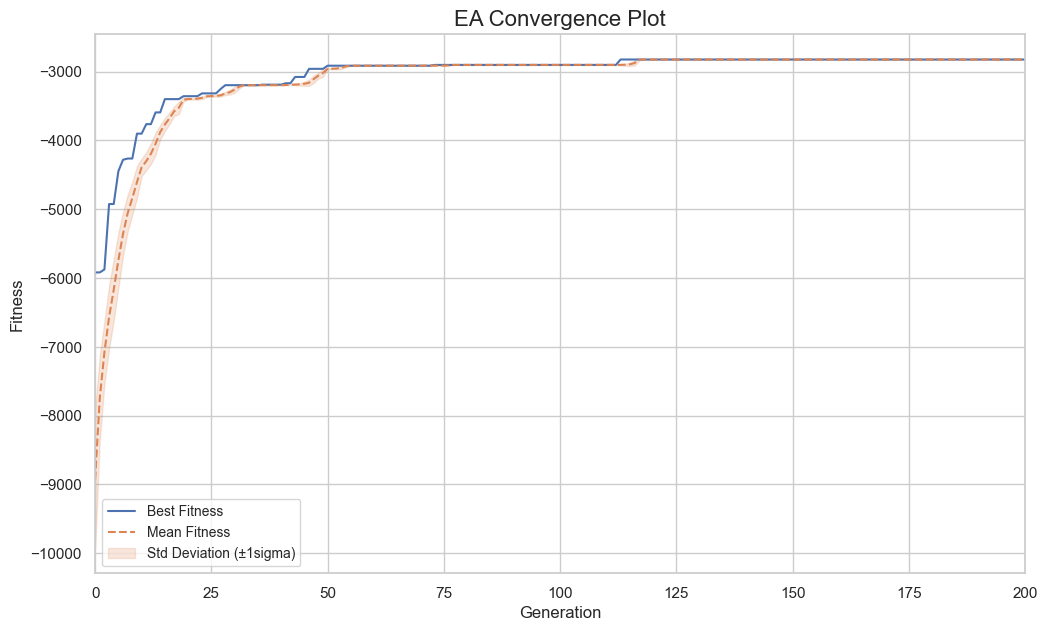

In [8]:
# We use the returned 'history' object to
# analyze the results and plot the convergence.

print("\n--- Analysis ---")

# Basic Analysis
best_fitness = best_individual.fitness
best_distance = -best_fitness  # Get the distance
best_path_indices = best_individual.genotype

# Map indices to city names
# Add the return to the start city for a complete tour
best_path_names = [CITIES_METADATA[i] for i in best_path_indices]
best_path_names.append(CITIES_METADATA[best_path_indices[0]]) 

print(f"\nBest Fitness Found: {best_fitness:.6f}")
print(f"Best Distance Found: {best_distance:.2f} km")
print(f"Best Path Found (Indices): {best_path_indices}")
print(f"Best Path (Names): \n{' -> '.join(best_path_names)}")


# Plotting
print("\nGenerating convergence plot...")

# Call our plotting function from the 'analysis' module
plot_convergence(
    history, 
    save_path=PLOT_SAVE_PATH, 
    show=True
)